In [1]:
#!pip install --upgrade tf_slim

import gym
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tf_slim as slim
import numpy.random as rnd
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
from collections import deque # container em forma de lista, com rapida insercao e remocao nas duas extremidades 
from ns3gym import ns3env

#from sklearn.preprocessing import label_binarize
#from keras.layers import Dense, Flatten, Reshape

/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sheila/

In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_random_seed(seed)#tf.random.set_seed(seed)
random.seed(seed)

In [3]:
env = gym.make('ns3-v0') # environment ID 

ob_space = env.observation_space
ac_space = env.action_space
print("Observation space: ", ob_space,  ob_space.dtype)
print("Action space: ", ac_space, ac_space.dtype)

# numero de estados
state_size = ob_space.shape[0]

# numero de acoes
action_size = ac_space.shape[0]

print("\n")
print("Numero de Estados: ", state_size)
print("Numero de Acoes: ", action_size) 

Got new port for ns3gm interface:  5913
Observation space:  Box(0, 100, (5,), uint64) uint64
Action space:  Box(0, 100, (5,), uint64) uint64


Numero de Estados:  5
Numero de Acoes:  5


In [4]:
numExecutions = 100

numOfEpisodes = 300 #300 #200
#numTimeSlots = 1000 #600 #495

discount_rate = 0.9999 # 0.75 gamma 0.618; 0.528; 0.95---- 70 e decay = 0.9999 graph points meet
learning_rate = 0.75 # Learning rate 0.7


rewards = []
iterations = []

# Epsilon greedy parameters
epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
max_epsilon = 1 # You can't explore more than 100% of the time
min_epsilon = 0.01 # At a minimum, we'll always explore 1% of the time
decay = 0.0999999999 #0.01
epsilon_vec = np.zeros((numOfEpisodes,))

maxNofCollisions = 3

batch_size = 512 #1024 #256 #128 # tamanho do batch 128

MIN_REPLAY_SIZE = 200000 # tamanho minimo da memoria de repeticao

inputQueues = 5
cwSize = 100

In [5]:
def createModel(inputQueues, cwSize, loss='mse'):
    learning_rate = 0.65 #0.678 #0.01 #0.678 #
    init = tf.keras.initializers.he_uniform()#tf.keras.initializers.HeUniform()
    model = keras.Sequential()
    # Input layer - número dos estados de entrada 
    model.add(keras.layers.Dense(inputQueues, input_shape=(inputQueues,), activation='relu', kernel_initializer=init))
    # Output layer - número de ações no ambiente
    model.add(keras.layers.Dense(cwSize, activation='linear', kernel_initializer=init))
    #model.add(keras.layers.Flatten())
    
    if(loss=='huber'):
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.Huber(), metrics=['accuracy'])
        print('Using Huber loss...', "\n")
    elif(loss=='mse'):
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['accuracy'])
        print('Using MSE loss...', "\n")
    else:
        print('Loss not defined...', "\n")
    return model

def train(replay_memory, model, model_target, done, batch_size, acc_history=[], loss_history=[]):
    mini_batch = random.sample(replay_memory, batch_size)
    c_states = np.array([transition[0] for transition in mini_batch])    
    #print("CSTATES", c_states, c_states.shape)
    current_qs_list  = model.predict(c_states)
    n_states = np.array([transition[3] for transition in mini_batch]) 
    future_qs_list = model_target.predict(n_states)
    
    
    X = []
    Y = []
    for index, (c_state, actionVec, reward, n_state, done) in enumerate(mini_batch):
        
        if not done:
            max_future_q = reward + discount_rate * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        
        current_qs = current_qs_list[index]
        #print("heyyyy")
        #action != 100
        for action in actionVec:
            if(action != 100):
                current_qs[action] = max_future_q

        X.append(c_state)
        Y.append(current_qs)

    # Train model with a mini-batch.
    history = model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

    # Store metrics.
    acc_history.append(history.history['acc'][0])
    loss_history.append(history.history['loss'][0])

    return history

In [6]:
print("Prediction Network")
# The first model makes the predictions for Q-values which are used to make a action.
model = createModel(inputQueues, cwSize)

print("Target Network")
# Build a target model for the prediction of future rewards.
model_target = createModel(inputQueues, cwSize)
# Initialize target model's weights.
model_target.set_weights(model.get_weights())

Prediction Network
Using MSE loss... 

Target Network
Using MSE loss... 



In [7]:
model.metrics_names

['loss', 'acc']

In [8]:
# numExecutions
for Execution in range(numExecutions):
#while n < numExecutions:
          
    
    acc_history = []
    loss_history = []

    episode_reward = np.zeros((numOfEpisodes,))
    max_reward =  np.zeros((numOfEpisodes,))
    replay_memory = deque(maxlen=1000_000)

    steps_to_update_target_model = 0
    
    print("Execution Num:", Execution)
    print("----------------------------", "\n")
    
    
    for episode in range(numOfEpisodes):

        #print('Episode:', episode)

        state = env.reset()
        state = np.reshape(state, [1, state_size])
        #state = np.array(state)

        done = False
        total_reward = 0


        i = 0
        # Run episode
        while True:

            if done:
                break

            i += 1

            steps_to_update_target_model += 1

            #print("Time Slot   :", iteration)
            #print("----------------------")

            #print("Estado atual:", state[0])

            # Escolha da ação.
            if np.random.uniform() >= epsilon:

                #predicted = model.predict(state.reshape(1,4))
                #action = np.argmax(predicted[0])

                act = model.predict(state)
                act = act.reshape(20,5)

                action0 = np.argmax(act[:,0])            
                action1 = np.argmax(act[:,1])
                action2 = np.argmax(act[:,2])
                action3 = np.argmax(act[:,3])
                action4 = np.argmax(act[:,4])

                    #print("Action (Q)")
            else:

                action0 = np.random.randint(cwSize)
                action1 = np.random.randint(cwSize)
                action2 = np.random.randint(cwSize)
                action3 = np.random.randint(cwSize)
                action4 = np.random.randint(cwSize)
                #print("Action (rnd)")


            actionVec = [action0, action1, action2, action3, action4]
            #print("ActionVec   :", actionVec)

            next_state, reward, done, _, _ = env.step(actionVec)



            next_state = np.reshape(next_state, [1, state_size])
            #next_state = np.array(next_state)
            #print("Next State  :", next_state[0])

            #print("Reward      : ", reward)

            # Add information to replay buffer.
            replay_memory.append([state[0], actionVec, reward, next_state[0], done])          

            # Accumulate reward.
            total_reward += reward

            episode_reward[episode] += reward

                # Plot received reward.
                #print("Reward      :", reward)
                #print("-------------", "\n")      



            # Train
            if len(replay_memory) >= MIN_REPLAY_SIZE:

                history = train(replay_memory, model, model_target, done, batch_size, acc_history, loss_history)

            # Is it the end of the episode?
            if done:

                # Update the the target network with new weights
                model_target.set_weights(model.get_weights())
                #print('########## Game Over ##########')
                break

                # updates the current state
                state = next_state

            #print("Episode:", episode, " Total reward:", total_reward)
            #print("------------------", "\n")

        if total_reward:
            rewards.append(total_reward)
            iterations.append(i)

        # Decrease epsilon along the way.
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
        epsilon_vec[episode] = epsilon 

        # Store maxmim possible reward per episode.
        #max_reward[episode] = iteration + 1
        max_reward[episode] = i + 1


    #print("Reward Append: ", rewards)
    #print("iteration append: ", iterations)

Execution Num: 0
---------------------------- 

currentNodeId=4 received 1 packets
currentNodeId=4 received 273 packets
Got new port for ns3gm interface:  5205
currentNodeId=4 received 276 packets
Got new port for ns3gm interface:  7254
currentNodeId=4 received 337 packets
Got new port for ns3gm interface:  7007
currentNodeId=4 received 301 packets
Got new port for ns3gm interface:  6829
currentNodeId=4 received 255 packets
Got new port for ns3gm interface:  6144
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5840
currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  9468
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  5713
currentNodeId=4 received 336 packets
Got new port for ns3gm interface:  9838
currentNodeId=4 received 297 packets
Got new port for ns3gm interface:  8457
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  5261
currentNodeId=4 received 372 packets
Got new port for ns3gm interface:

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7966
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6797
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6134
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9175
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9043
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5745
currentNodeId=4 received 277 packets
Got new port for ns3gm interface:  5386
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5899
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6253
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6311
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8459
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9886
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5521

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9721
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8873
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6991
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8875
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8335
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6560
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5773
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  5795
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  8532
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7903
currentNodeId=4 received 322 packets
Got new port for ns3gm interface:  8470
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8368
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8826

currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  9613
currentNodeId=4 received 384 packets
Got new port for ns3gm interface:  5820
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  5601
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  9405
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  6747
currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  9145
currentNodeId=4 received 367 packets
Got new port for ns3gm interface:  7173
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  6086
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  7860
currentNodeId=4 received 383 packets
Got new port for ns3gm interface:  5564
currentNodeId=4 received 330 packets
Got new port for ns3gm interface:  7002
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8028
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7335

currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8275
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9393
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  7713
currentNodeId=4 received 335 packets
Got new port for ns3gm interface:  5227
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5945
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7140
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6463
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9757
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  7175
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  5314
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5889
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9888
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  8560

currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9878
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7600
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8626
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9136
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8496
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9489
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8653
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6304
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8889
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8687
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7124
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  7026
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7272

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6955
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6035
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  8880
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5938
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9621
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6786
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8810
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  7100
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8022
currentNodeId=4 received 346 packets
Got new port for ns3gm interface:  6375
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  9964
currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  9975
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5939

currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  7710
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7883
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8718
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7220
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7512
currentNodeId=4 received 342 packets
Got new port for ns3gm interface:  7060
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6889
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5989
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6578
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7585
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  5980
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  9390
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6517

currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8483
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5941
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9462
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6842
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6221
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7177
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6166
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5585
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5489
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6360
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  7520
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  9875
currentNodeId=4 received 321 packets
Got new port for ns3gm interface:  9663

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9083
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7391
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  9169
currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  7240
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8404
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8953
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8869
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6997
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  8742
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9516
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6185
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  8143
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6562

currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  9993
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8134
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6973
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  9077
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9778
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6173
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6903
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8778
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7081
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8765
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7092
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5077
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8812

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7476
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8345
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5956
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6146
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5372
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5305
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7494
currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  9036
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5952
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5797
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  6924
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9404
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6112

currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5603
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  5662
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  7639
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9984
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  6216
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5539
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6034
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7253
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  9796
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9493
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7664
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8121
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9894

currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9650
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9885
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5696
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5431
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6275
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  6290
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5408
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5669
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  7230
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  8630
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  8474
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8979
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  9974

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9048
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8801
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  9619
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  9748
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8678
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9625
Execution Num: 5
---------------------------- 

currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7648
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7590
currentNodeId=4 received 289 packets
Got new port for ns3gm interface:  6237
currentNodeId=4 received 309 packets
Got new port for ns3gm interface:  8603
currentNodeId=4 received 306 packets
Got new port for ns3gm interface:  5560
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  8842
currentNodeId=4 received 322

currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6127
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6270
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  5633
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7424
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5829
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9159
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  9422
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  9314
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5310
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  7759
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6074
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9893
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8087

currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  5909
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9095
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9889
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9392
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5135
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9222
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9711
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6982
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6177
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  7387
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8517
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5013
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  7891

currentNodeId=4 received 258 packets
Got new port for ns3gm interface:  8663
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  5347
currentNodeId=4 received 299 packets
Got new port for ns3gm interface:  7889
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  8564
currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  7250
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  5470
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  5615
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  8328
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  7977
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  9204
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  6311
currentNodeId=4 received 306 packets
Got new port for ns3gm interface:  5256
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  6170

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6058
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8545
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9120
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5454
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6018
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9245
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6254
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7492
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6349
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  6327
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  7644
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6848
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7835

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5399
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5415
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7305
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9055
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9895
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  8856
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  7341
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9397
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  5067
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5881
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8531
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6098
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7167

currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  5511
currentNodeId=4 received 381 packets
Got new port for ns3gm interface:  6132
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  9250
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6699
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9595
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  7663
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8919
currentNodeId=4 received 336 packets
Got new port for ns3gm interface:  9305
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8087
currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  7571
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  6419
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8766
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9368

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6100
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9131
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8835
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7236
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6580
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5923
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7709
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6332
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8760
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7108
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6526
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5116
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7762

currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  8244
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7085
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  5025
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6786
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  9738
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5599
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  5372
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8471
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7823
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5523
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9434
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  5494
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5566

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6507
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9407
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8880
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6975
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  6847
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7464
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  6183
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8794
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5473
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9608
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  8381
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8413
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9566

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5609
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  5398
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5053
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8379
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6127
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6896
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5557
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  6238
currentNodeId=4 received 316 packets
Got new port for ns3gm interface:  5075
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6792
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9143
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8736
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8058

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9958
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9880
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8250
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7674
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5243
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  7240
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8691
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9020
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6869
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7915
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9531
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8076
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8538

currentNodeId=4 received 341 packets
Got new port for ns3gm interface:  7574
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6456
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  8263
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7615
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7388
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9023
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9718
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6986
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7670
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8081
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7297
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8219
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7991

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6999
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9228
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6430
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9522
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6312
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7712
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9587
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8493
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8786
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6900
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8319
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6512
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6527

currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8747
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9634
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9058
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9504
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  9185
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5928
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9692
currentNodeId=4 received 404 packets
Got new port for ns3gm interface:  5936
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7195
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9450
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  8006
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9441
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  5341

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6295
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8616
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8740
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5006
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8505
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6658
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6081
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7473
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6303
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  7245
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5765
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  7953
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7052

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9657
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8448
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7994
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9476
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6416
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8859
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5598
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5137
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9812
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5554
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5113
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7148
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6768

currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  7034
currentNodeId=4 received 302 packets
Got new port for ns3gm interface:  8410
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7621
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  7223
currentNodeId=4 received 267 packets
Got new port for ns3gm interface:  5639
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  9683
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  8055
currentNodeId=4 received 368 packets
Got new port for ns3gm interface:  5979
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  9113
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  5432
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  6470
currentNodeId=4 received 371 packets
Got new port for ns3gm interface:  6829
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  9226

currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  5983
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5741
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6292
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  7493
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  9943
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  5331
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6762
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7686
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6216
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5748
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  7034
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  7915
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8247

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7929
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9785
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6907
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6308
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5821
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  7031
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6976
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7184
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9372
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5459
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6798
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  9717
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8182

currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  7045
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  5556
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7872
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7103
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  5886
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5011
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  5395
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8162
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  8590
currentNodeId=4 received 308 packets
Got new port for ns3gm interface:  8438
currentNodeId=4 received 344 packets
Got new port for ns3gm interface:  6363
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  8392
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9040

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5793
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5703
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7817
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9436
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8392
currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  9832
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6864
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9536
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5500
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  8172
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9281
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8430
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9387

currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5732
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  6540
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8619
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  6732
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8336
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8969
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9232
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  8064
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5461
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9222
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6303
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5538
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  7549

currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6969
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5466
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  9916
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  8311
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  7619
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6147
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  5209
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9075
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7422
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7126
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8429
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8315
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8181

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7821
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  7557
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6057
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5842
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8143
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9124
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9823
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  7508
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6369
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5535
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5375
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7443
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7383

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5411
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5818
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6432
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  5324
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  7381
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  7951
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7562
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  8490
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5950
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  5779
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  5376
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  5080
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6134

currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  5294
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9565
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  9499
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5002
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5745
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9950
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7496
currentNodeId=4 received 323 packets
Got new port for ns3gm interface:  9165
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  9607
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  6695
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8738
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  7793
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7977

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9607
currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  8936
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9775
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  9675
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8420
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9374
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7343
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8461
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5105
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9283
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5873
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5208
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8121

currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7405
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6790
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9346
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8891
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9599
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5073
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  5940
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7835
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8651
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  6969
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  6998
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5327
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7630

currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  9692
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9888
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8229
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9401
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9486
currentNodeId=4 received 290 packets
Got new port for ns3gm interface:  5698
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7497
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6721
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7817
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6735
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8381
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  9199
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6167

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7981
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  9114
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  5087
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6957
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6359
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9212
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  6150
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  8656
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6305
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6468
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9640
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9636
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6198

Execution Num: 16
---------------------------- 

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6775
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8680
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  9969
currentNodeId=4 received 231 packets
Got new port for ns3gm interface:  8862
currentNodeId=4 received 304 packets
Got new port for ns3gm interface:  8946
currentNodeId=4 received 336 packets
Got new port for ns3gm interface:  6398
currentNodeId=4 received 324 packets
Got new port for ns3gm interface:  6798
currentNodeId=4 received 298 packets
Got new port for ns3gm interface:  8366
currentNodeId=4 received 330 packets
Got new port for ns3gm interface:  9923
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  6170
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  9774
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  6490
currentNodeId=4 received 35

currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7079
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7513
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  9733
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  7821
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8262
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6132
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  5976
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6883
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8659
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6326
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5822
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6757
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9165

currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  9808
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5225
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8949
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5953
currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  7113
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5554
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8135
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6806
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6884
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7587
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8379
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7893
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9232

currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  6474
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  9681
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  6075
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  9718
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  6873
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  5819
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  7212
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  6932
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  9550
currentNodeId=4 received 372 packets
Got new port for ns3gm interface:  8541
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8121
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  6607
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6195

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8253
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9293
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5682
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5852
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7151
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6273
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5691
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8194
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7535
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  6879
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7027
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7328
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  8631

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5838
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7312
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  7206
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6025
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8592
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5068
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6908
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5739
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  6235
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5121
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9044
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6780
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7801

currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  7415
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9447
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9015
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6555
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  9643
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  6529
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9454
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7849
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  7652
currentNodeId=4 received 344 packets
Got new port for ns3gm interface:  8838
currentNodeId=4 received 346 packets
Got new port for ns3gm interface:  7256
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  9905
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  9543

currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  6367
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6478
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9506
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8290
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9135
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  7765
currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  6296
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9374
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9915
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  8630
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  7887
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7582
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  9507

currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9876
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9713
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9135
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  5738
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6820
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8539
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7374
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8231
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6213
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6083
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7754
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5677
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8899

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7397
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  8167
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  6894
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8119
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9166
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5816
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7585
currentNodeId=4 received 368 packets
Got new port for ns3gm interface:  8971
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9892
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9355
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5722
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6528
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6630

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8841
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8064
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6508
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  8175
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9026
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  8882
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6127
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6342
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6584
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6854
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5265
currentNodeId=4 received 368 packets
Got new port for ns3gm interface:  8348
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5123

currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6466
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5421
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8438
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7524
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7536
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  8656
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7366
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6481
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5964
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6078
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6662
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5029
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7074

currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  9993
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6907
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7380
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6586
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  5013
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5969
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5197
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8809
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5967
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6699
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8397
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8392
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5373

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5805
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9229
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6088
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6681
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5300
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8764
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8176
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9280
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5949
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5034
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  7548
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5361
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9869

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6400
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7313
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  7856
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9952
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9708
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6044
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9162
Execution Num: 21
---------------------------- 

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5844
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8324
currentNodeId=4 received 297 packets
Got new port for ns3gm interface:  5877
currentNodeId=4 received 279 packets
Got new port for ns3gm interface:  7670
currentNodeId=4 received 308 packets
Got new port for ns3gm interface:  9556
currentNodeId=4 received 31

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6731
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6421
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8891
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  6140
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6542
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9551
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  8151
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7952
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8418
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6264
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7364
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6029
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  6101

currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7065
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6086
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7302
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7255
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7105
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5117
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  5914
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9947
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6431
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9848
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6239
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  8659
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  8030

currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  8080
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  9638
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6514
currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  5909
currentNodeId=4 received 371 packets
Got new port for ns3gm interface:  6510
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  7076
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  7414
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  8826
currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  5621
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  8715
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  7265
currentNodeId=4 received 383 packets
Got new port for ns3gm interface:  8498
currentNodeId=4 received 312 packets
Got new port for ns3gm interface:  7650

currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  5517
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9429
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7521
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9094
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9375
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8681
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  5135
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  5304
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7780
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5460
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7767
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  5351
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8322

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6931
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6573
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5963
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9344
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  5784
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  7965
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  9422
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9158
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6797
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  8803
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  6705
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7265
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5435

currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  7287
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  5119
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8508
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7021
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7031
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7682
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8558
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9747
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  6822
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9848
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6221
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9700
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  5042

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9358
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9366
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7395
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8703
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8016
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5538
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6543
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  8751
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5716
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5657
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8201
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6465
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7363

currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7422
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8883
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7375
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  9700
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6205
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  9631
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8622
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7775
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5921
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  8924
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5329
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6143
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9514

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6262
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7152
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7459
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8872
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  6018
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7357
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8418
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6470
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9030
currentNodeId=4 received 315 packets
Got new port for ns3gm interface:  7005
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  5234
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5978
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7271

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6857
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  7519
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6027
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6720
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6067
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5644
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8481
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5916
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  5637
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5155
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8968
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8533
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5349

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9028
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5862
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  8248
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8589
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9282
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5697
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5977
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6175
currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  8235
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  8282
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9838
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5834
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6383

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8207
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7158
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9053
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  9842
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8095
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7890
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7331
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7626
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5504
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  5231
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  9838
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5370
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6051

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9486
currentNodeId=4 received 384 packets
Got new port for ns3gm interface:  6480
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  5153
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9229
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6529
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9726
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9090
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6745
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8829
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7195
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9365
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8554
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9638

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9471
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  8472
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8891
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7019
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  7276
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6188
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7974
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8894
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8013
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7525
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5173
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9963
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5286

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7132
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6223
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5730
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8015
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6394
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  9647
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5962
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  5116
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9308
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  8565
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8717
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9049
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5971

currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8605
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5436
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6548
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6218
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5448
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6884
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6501
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  5294
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8853
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7132
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6340
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8827
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  8576

currentNodeId=4 received 308 packets
Got new port for ns3gm interface:  8650
currentNodeId=4 received 338 packets
Got new port for ns3gm interface:  8180
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  8903
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  7200
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  9613
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  9918
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  8466
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  5740
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  8462
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  8017
currentNodeId=4 received 339 packets
Got new port for ns3gm interface:  6527
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  8557
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8490

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6190
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6981
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8570
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9413
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6564
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5706
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7466
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8797
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6214
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8883
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8457
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5179
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5955

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5262
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  5522
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  7767
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8528
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  5934
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6858
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5989
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9604
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6836
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8985
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7113
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7788
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  7911

currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  9460
currentNodeId=4 received 341 packets
Got new port for ns3gm interface:  8623
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7829
currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  8314
currentNodeId=4 received 381 packets
Got new port for ns3gm interface:  6617
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  7471
currentNodeId=4 received 371 packets
Got new port for ns3gm interface:  5691
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  5303
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  9403
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  7741
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8195
currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  6033
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9264

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8878
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5268
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6285
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9580
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8026
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5973
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9929
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8348
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  5904
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5991
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8028
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9684
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7373

currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6479
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  8400
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5198
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9325
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  7600
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8130
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7107
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5746
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5940
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5814
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9439
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  6378
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7338

currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  8239
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  6008
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6145
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9559
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7290
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8539
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6728
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9136
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  7608
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  7807
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7142
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8709
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  7237

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9246
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8823
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  9060
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7962
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9238
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5357
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6840
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  5385
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  7277
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8442
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9362
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8678
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  7591

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6128
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5362
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5496
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6046
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7554
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9789
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8571
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9204
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7931
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7550
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9782
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9434
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6193

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8029
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8051
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6404
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9317
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8554
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  5536
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  5971
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6184
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6072
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  6554
currentNodeId=4 received 346 packets
Got new port for ns3gm interface:  6571
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  9363
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8099

currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7265
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6866
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5807
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5972
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  5585
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7952
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  5314
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  9474
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6641
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7735
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  6611
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  7698
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7049

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7326
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6687
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6910
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  7385
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9296
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  5574
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8725
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5471
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8020
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9248
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  5091
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6408
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7677

currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7053
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5940
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6119
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  7680
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8804
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8972
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  8780
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5559
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5677
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  9493
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  6985
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8586
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  6149

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7064
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5777
currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  9915
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  7658
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8184
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6089
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7721
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  6437
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7605
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  8950
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5554
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7746
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5145

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8616
Execution Num: 32
---------------------------- 

currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  8463
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9140
currentNodeId=4 received 303 packets
Got new port for ns3gm interface:  9993
currentNodeId=4 received 332 packets
Got new port for ns3gm interface:  8551
currentNodeId=4 received 326 packets
Got new port for ns3gm interface:  6277
currentNodeId=4 received 263 packets
Got new port for ns3gm interface:  8949
currentNodeId=4 received 314 packets
Got new port for ns3gm interface:  5163
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  8125
currentNodeId=4 received 342 packets
Got new port for ns3gm interface:  8502
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  5682
currentNodeId=4 received 312 packets
Got new port for ns3gm interface:  7460
currentNodeId=4 received 38

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6717
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8261
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7524
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5053
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  6380
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9029
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5013
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5794
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5573
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8423
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9301
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8415
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  7363

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8970
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8279
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  5667
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  7854
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8506
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8901
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5823
currentNodeId=4 received 384 packets
Got new port for ns3gm interface:  8153
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7408
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9974
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  6599
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6173
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9261

currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7623
currentNodeId=4 received 328 packets
Got new port for ns3gm interface:  7531
currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  9116
currentNodeId=4 received 324 packets
Got new port for ns3gm interface:  6012
currentNodeId=4 received 340 packets
Got new port for ns3gm interface:  7241
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  9702
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  8919
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  6768
currentNodeId=4 received 372 packets
Got new port for ns3gm interface:  9056
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  7388
currentNodeId=4 received 372 packets
Got new port for ns3gm interface:  8086
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  5482
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  7730

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9857
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6484
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  8146
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8967
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8553
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7445
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9682
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6026
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5815
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7665
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5521
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  9404
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  6515

currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9956
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6344
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8439
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  6258
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7592
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  8553
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8105
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5213
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9945
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7028
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5636
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  7213
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6021

currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  8930
currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  9079
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  9219
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  9362
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6022
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  8322
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5114
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6558
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5060
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8482
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9378
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7827
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  7001

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8450
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7714
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5259
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6314
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6631
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8927
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7178
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5974
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8450
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9007
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9507
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9060
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6044

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9025
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7979
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  7739
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7494
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  5914
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5794
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5112
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9521
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6068
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7714
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7954
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7961
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9825

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5321
currentNodeId=4 received 321 packets
Got new port for ns3gm interface:  6214
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  7276
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6090
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7216
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5423
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7040
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6721
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9380
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5952
currentNodeId=4 received 381 packets
Got new port for ns3gm interface:  5012
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7847
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9958

currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  7519
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7718
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  8924
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6266
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6998
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5458
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  9453
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7192
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9454
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6009
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5174
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5365
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  5843

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9734
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6797
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5715
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6927
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7964
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5024
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6666
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5141
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7969
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9575
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  8883
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6095
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5903

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7212
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5889
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5856
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5638
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  7972
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9942
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7749
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5230
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  6963
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7312
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6334
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9437
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5873

currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5583
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6468
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8775
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7114
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8877
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7098
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  8622
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6151
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  6016
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9660
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9000
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5325
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7978

currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  7802
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7433
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6348
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  6627
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  7862
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8434
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  8946
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  8896
Execution Num: 37
---------------------------- 

currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  9387
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6317
currentNodeId=4 received 294 packets
Got new port for ns3gm interface:  8579
currentNodeId=4 received 303 packets
Got new port for ns3gm interface:  7906
currentNodeId=4 received 33

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5938
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6603
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8847
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6020
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7873
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8801
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8383
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8243
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5063
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8070
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6835
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9158
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7324

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5825
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9023
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  5180
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8390
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5603
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8986
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5626
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6723
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  8440
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8075
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  7569
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8694
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6320

currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  8518
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  6524
currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  7931
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  7010
currentNodeId=4 received 327 packets
Got new port for ns3gm interface:  5596
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  6763
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  8045
currentNodeId=4 received 372 packets
Got new port for ns3gm interface:  8048
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6189
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  7576
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  6002
currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  5079
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  7610

currentNodeId=4 received 404 packets
Got new port for ns3gm interface:  7128
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5353
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5908
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5394
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7493
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5615
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7161
currentNodeId=4 received 322 packets
Got new port for ns3gm interface:  7698
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8110
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7212
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6396
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6129
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9780

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8616
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  7234
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8030
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5802
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5403
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8134
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8462
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6589
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7409
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6552
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8299
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6448
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9867

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9243
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  9881
currentNodeId=4 received 370 packets
Got new port for ns3gm interface:  8968
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  5924
currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  7212
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  9255
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5170
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  6212
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8362
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  6805
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6161
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7927
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9079

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8571
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7642
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  9737
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6141
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6635
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7049
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6112
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8411
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9541
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6635
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7467
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7499
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5702

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8963
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6508
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6925
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9479
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7133
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8598
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6010
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8542
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6199
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5178
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6514
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6161
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6972

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7052
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5938
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5307
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5598
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  8618
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8067
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9969
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5242
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6426
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7631
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5882
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8683
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8094

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5511
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6931
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9044
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5598
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9620
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9998
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  5290
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  7834
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5580
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8410
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  9901
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  5661
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9518

currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8984
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  7292
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5643
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6668
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6124
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9268
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6889
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7499
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  9530
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6727
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6006
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8051
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6163

currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  8934
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9560
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6785
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8348
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5480
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9748
currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  5652
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7265
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9518
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7573
currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  5525
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8609
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6473

currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8613
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  7597
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7206
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6598
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9713
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7401
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7000
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7693
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  6992
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  7966
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6892
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8735
currentNodeId=4 received 322 packets
Got new port for ns3gm interface:  7579

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6448
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9168
currentNodeId=4 received 384 packets
Got new port for ns3gm interface:  9818
currentNodeId=4 received 315 packets
Got new port for ns3gm interface:  7289
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5794
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6903
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7436
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  9042
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7795
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5396
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9622
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9241
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9303

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8082
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6804
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  6603
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7174
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8852
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6241
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8970
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  6533
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9070
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7316
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6080
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6627
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  5727

currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9530
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  5520
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  5404
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9249
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6725
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  7967
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9387
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6626
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6287
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9389
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  8241
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  6879
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7378

currentNodeId=4 received 271 packets
Got new port for ns3gm interface:  9595
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  6387
currentNodeId=4 received 338 packets
Got new port for ns3gm interface:  6702
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  9013
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  9862
currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  7048
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  5688
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  6158
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  8303
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  8880
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  9288
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  9642
currentNodeId=4 received 346 packets
Got new port for ns3gm interface:  6905

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8840
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9870
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6282
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5547
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7871
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9581
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6852
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7826
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5116
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6579
currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  7250
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7329
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8492

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6597
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5046
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9803
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  7543
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7691
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5771
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8022
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  7079
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9119
currentNodeId=4 received 383 packets
Got new port for ns3gm interface:  5107
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  9971
currentNodeId=4 received 308 packets
Got new port for ns3gm interface:  7237
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5275

currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  8108
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  7352
currentNodeId=4 received 315 packets
Got new port for ns3gm interface:  6459
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  7286
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  6151
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  9629
currentNodeId=4 received 371 packets
Got new port for ns3gm interface:  7585
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  8392
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  6852
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6543
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  7235
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6633
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6451

currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  9196
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  6364
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7463
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9890
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  9294
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6626
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9653
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6144
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6065
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7730
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5441
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5741
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7534

currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  8314
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5101
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6318
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7614
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6055
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  9708
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9154
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8146
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  8725
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5095
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  8983
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  8291
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  8461

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6507
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  7105
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5650
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8551
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  5954
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6570
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9677
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7138
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7484
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9212
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9417
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6997
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5401

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8242
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  6789
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6732
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5907
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9676
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  7371
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6464
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6304
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8286
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  9507
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  8347
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7884
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6784

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8417
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7131
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  9402
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5992
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9973
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9376
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5195
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8593
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8939
currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  5490
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7400
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8264
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5327

currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7805
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  6842
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7534
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  6692
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  6838
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6230
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7280
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9986
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5980
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6614
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7921
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9087
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  8763

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9598
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7530
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  8605
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5914
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6493
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8995
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5054
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7615
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9175
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8855
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9062
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6337
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6465

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9802
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8073
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  5486
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5831
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5460
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7808
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7262
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9407
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8027
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8590
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7329
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  5910
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8866

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7407
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  5053
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  8195
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5155
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5070
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6846
currentNodeId=4 received 324 packets
Got new port for ns3gm interface:  7641
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8500
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6233
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7121
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6826
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9788
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7676

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5372
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6153
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7040
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6453
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  9626
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5076
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6049
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  9249
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6276
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6149
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8849
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  5320
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5502

currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6190
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9747
Execution Num: 48
---------------------------- 

currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  5281
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8155
currentNodeId=4 received 289 packets
Got new port for ns3gm interface:  5394
currentNodeId=4 received 326 packets
Got new port for ns3gm interface:  6622
currentNodeId=4 received 316 packets
Got new port for ns3gm interface:  6493
currentNodeId=4 received 276 packets
Got new port for ns3gm interface:  5118
currentNodeId=4 received 312 packets
Got new port for ns3gm interface:  6172
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  5280
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  6949
currentNodeId=4 received 368 packets
Got new port for ns3gm interface:  6327
currentNodeId=4 received 34

currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  6116
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7458
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  5003
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5614
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7059
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9553
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7553
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6711
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9866
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5548
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5486
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8362
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6150

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8135
currentNodeId=4 received 383 packets
Got new port for ns3gm interface:  5345
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9929
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5884
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9837
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9716
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5778
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5963
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6955
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  7955
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9753
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  9947
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8456

currentNodeId=4 received 372 packets
Got new port for ns3gm interface:  9671
currentNodeId=4 received 381 packets
Got new port for ns3gm interface:  5674
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  7653
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  6842
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  8626
currentNodeId=4 received 346 packets
Got new port for ns3gm interface:  5335
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  7015
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9490
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  6270
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  7243
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  5216
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  9051
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  6839

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9421
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9808
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7577
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5056
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  9994
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5434
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7936
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9813
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5981
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5582
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  5522
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9340
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8390

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6272
currentNodeId=4 received 404 packets
Got new port for ns3gm interface:  7764
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8725
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9490
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8186
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8670
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5954
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  9543
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5537
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7772
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7018
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7996
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  6159

currentNodeId=4 received 239 packets
Got new port for ns3gm interface:  8195
currentNodeId=4 received 383 packets
Got new port for ns3gm interface:  6871
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  8046
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8293
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  5367
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6278
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6161
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9905
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  7017
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7116
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8464
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  9674
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7538

currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7014
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9929
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9330
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7358
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9562
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6320
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  6175
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9483
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7602
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5465
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5913
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5534
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8359

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7461
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8377
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5417
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  6634
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6780
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7767
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9520
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6284
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8149
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9240
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8538
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6478
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  8629

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6615
currentNodeId=4 received 329 packets
Got new port for ns3gm interface:  7628
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7395
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5681
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7906
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9939
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  9053
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5131
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9836
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8423
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6385
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7992
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7071

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6579
currentNodeId=4 received 314 packets
Got new port for ns3gm interface:  8900
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6617
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9058
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9960
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6525
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8844
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7360
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9849
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  5502
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8626
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6515
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  9159

currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5135
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8206
currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  8869
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6228
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7220
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  7764
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  6621
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  5178
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  9075
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8214
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6297
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7487
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  9501

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6830
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5026
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7681
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7918
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8954
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  9603
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6198
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  7235
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7622
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8971
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  7574
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9955
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9394

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8411
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8244
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  6270
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9491
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5733
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6698
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8675
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  6304
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5945
currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  7137
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6863
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6961
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5463

currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  6691
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9093
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8184
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  7682
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8751
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8202
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9931
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6354
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9028
Execution Num: 53
---------------------------- 

currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  8934
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9595
currentNodeId=4 received 285 packets
Got new port for ns3gm interface:  9889
currentNodeId=4 received 24

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8058
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8042
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9514
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  9430
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6194
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7628
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7841
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8335
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6426
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9754
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8292
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  8049
currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  8830

currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  7812
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8177
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  8072
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6708
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  7489
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  8511
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  9831
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8920
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9861
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5344
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9026
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5259
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9096

currentNodeId=4 received 327 packets
Got new port for ns3gm interface:  9611
currentNodeId=4 received 275 packets
Got new port for ns3gm interface:  5194
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  8589
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  9065
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  8004
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  8523
currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  5169
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  9303
currentNodeId=4 received 331 packets
Got new port for ns3gm interface:  8018
currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  9453
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  5872
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  8430
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  8881

currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  8685
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9968
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6841
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6044
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8927
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  9175
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8331
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  6289
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6978
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9907
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9271
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7357
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9073

currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5591
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7069
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6020
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8085
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  9512
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8221
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  5027
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5546
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6548
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7088
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9056
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8726
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  9511

currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  8639
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8626
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  6232
currentNodeId=4 received 383 packets
Got new port for ns3gm interface:  8150
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  8115
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  5189
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9435
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  7226
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  6681
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  9027
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  8578
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9293
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7805

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8853
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8468
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6376
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6936
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5141
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6601
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  9937
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5632
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5552
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5832
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7205
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6465
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9375

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8597
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7072
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8988
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8271
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8821
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  8811
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8044
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  6677
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8796
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6069
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8407
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5421
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7011

currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  5542
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  6795
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8837
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6357
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9043
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5936
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  5656
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8766
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7808
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8049
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  8842
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7115
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  9728

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5268
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6094
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7388
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8005
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7927
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9686
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5717
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5332
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6354
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7538
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7705
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5819
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5320

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6508
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5061
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6345
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7053
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8407
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5764
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8989
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  7741
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  6214
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5345
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6150
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6967
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9201

currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  6641
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5117
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8519
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  5653
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7694
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7012
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8932
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5170
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  5815
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  6064
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7116
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6385
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7395

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5955
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9857
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6113
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8879
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9050
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  9535
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9519
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  7792
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5982
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5267
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7598
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7016
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7557

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6388
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  9176
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  6955
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8342
currentNodeId=4 received 344 packets
Got new port for ns3gm interface:  5044
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9285
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7239
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9725
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6537
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9036
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9486
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  6949
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5487

currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8492
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5113
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8877
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9339
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5535
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9805
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8723
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7850
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7484
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6838
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8682
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6646
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  7258

currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5841
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  9494
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8615
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6112
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6809
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6758
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6790
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8039
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  5794
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5300
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  7101
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  5096
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9813

currentNodeId=4 received 304 packets
Got new port for ns3gm interface:  9848
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  9798
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  7704
currentNodeId=4 received 344 packets
Got new port for ns3gm interface:  8712
currentNodeId=4 received 342 packets
Got new port for ns3gm interface:  6290
currentNodeId=4 received 293 packets
Got new port for ns3gm interface:  9869
currentNodeId=4 received 257 packets
Got new port for ns3gm interface:  9366
currentNodeId=4 received 342 packets
Got new port for ns3gm interface:  9648
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  6767
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  8679
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  8481
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6411
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  8647

currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8106
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5944
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9129
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7375
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7394
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  7137
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6305
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  5697
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9471
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  6212
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9919
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9722
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  9424

currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  7194
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6985
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6269
currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  5537
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6160
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8278
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7418
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6400
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9274
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  9682
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7520
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8340
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7438

currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  6622
currentNodeId=4 received 349 packets
Got new port for ns3gm interface:  9036
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6776
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  6104
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  8318
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7647
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  6850
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  5322
currentNodeId=4 received 336 packets
Got new port for ns3gm interface:  8332
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  5285
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5630
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  5688
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9137

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8240
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  8512
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  8567
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5380
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9255
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5787
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5955
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6056
currentNodeId=4 received 257 packets
Got new port for ns3gm interface:  8495
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5148
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5346
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6581
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5454

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6190
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9385
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8000
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9746
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8147
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9660
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7034
currentNodeId=4 received 372 packets
Got new port for ns3gm interface:  6204
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  7707
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9632
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5844
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  7412
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5175

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9170
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  7228
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5333
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5242
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6346
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  8920
currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  6833
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5009
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5054
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9210
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8558
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9919
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8201

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5833
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5644
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  9940
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6339
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5004
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8112
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5923
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6793
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  8457
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  6950
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9205
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7604
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6085

currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  6933
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8319
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  9246
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  6201
currentNodeId=4 received 384 packets
Got new port for ns3gm interface:  5127
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  7991
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  5019
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8082
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9429
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6177
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5692
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  6401
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6479

currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  9708
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8576
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9144
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9074
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6261
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6061
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  7623
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9229
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9726
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6607
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9047
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5313
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9360

currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6837
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5063
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6591
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7512
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  5983
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9197
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9727
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5611
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5928
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8943
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  9908
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  8967
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6351

currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  7600
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  7360
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6457
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9113
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  6056
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7495
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  5973
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5680
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  8508
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7723
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5209
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6116
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5052

currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  7868
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8933
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8804
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7629
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7133
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7976
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9605
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7177
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8964
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6112
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8105
currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  6268
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9680

currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9318
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9078
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  5922
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6756
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9017
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  7678
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6133
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9748
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9574
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9252
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6991
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6071
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  6223

currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5950
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5924
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8135
Execution Num: 64
---------------------------- 

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8299
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5857
currentNodeId=4 received 244 packets
Got new port for ns3gm interface:  6061
currentNodeId=4 received 296 packets
Got new port for ns3gm interface:  6481
currentNodeId=4 received 301 packets
Got new port for ns3gm interface:  5343
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5991
currentNodeId=4 received 310 packets
Got new port for ns3gm interface:  5262
currentNodeId=4 received 321 packets
Got new port for ns3gm interface:  8658
currentNodeId=4 received 332 packets
Got new port for ns3gm interface:  6115
currentNodeId=4 received 33

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9908
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5504
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8630
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  5700
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8533
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8492
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9840
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5184
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8378
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6870
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6065
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6037
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  7306

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7460
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6635
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8282
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6434
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  5936
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6611
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  5204
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  5143
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  9630
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8565
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6489
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7859
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  9356

currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  9940
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  9560
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  7398
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  5837
currentNodeId=4 received 336 packets
Got new port for ns3gm interface:  8366
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  8130
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5816
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  6217
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  6772
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  8973
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  7349
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5403
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  8974

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6548
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  8116
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9616
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  5698
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7454
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9880
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8304
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5750
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5689
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6293
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  9186
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9094
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9837

currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  8929
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6240
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9319
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  8647
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9932
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9717
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  5559
currentNodeId=4 received 323 packets
Got new port for ns3gm interface:  8481
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5181
currentNodeId=4 received 384 packets
Got new port for ns3gm interface:  5520
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5731
currentNodeId=4 received 376 packets
Got new port for ns3gm interface:  7457
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5606

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7682
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  7788
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  9820
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7140
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  7569
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5404
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5907
currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  6017
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6105
currentNodeId=4 received 282 packets
Got new port for ns3gm interface:  9908
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  6480
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5480
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8914

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9946
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9983
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  7843
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6876
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  5440
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5076
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  8486
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6313
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6530
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  5971
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6433
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6247
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7410

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8828
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7774
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6194
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6613
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  5629
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5913
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6147
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6586
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6263
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  8666
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7339
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9402
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9025

currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9323
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9215
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6270
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9906
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5500
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7508
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7577
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8943
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9742
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6089
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  8927
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5858
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7247

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8348
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9823
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7592
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5801
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5286
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5030
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6627
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  5139
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8745
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8312
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6495
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5029
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8032

currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6531
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8115
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5121
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7480
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5645
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9533
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  5048
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9683
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  8020
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6141
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5597
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8777
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7960

currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5739
currentNodeId=4 received 346 packets
Got new port for ns3gm interface:  6117
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8439
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5594
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8191
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9443
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8057
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5052
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8945
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5540
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5483
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7879
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9608

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7237
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9471
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8567
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5319
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8517
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8669
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6588
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9820
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  9489
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6795
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7060
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  7455
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9440

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5263
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8589
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  7315
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5360
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9034
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  5819
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8629
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6567
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6058
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8799
Execution Num: 69
---------------------------- 

currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  9874
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9512
currentNodeId=4 received 29

currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5598
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9041
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6741
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8109
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7565
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7090
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6066
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  8205
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  6505
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7342
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  5867
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8764
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9402

currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9297
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  6020
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9279
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9693
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9005
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5036
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7999
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9633
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5774
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  8554
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  5872
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  5919
currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  8577

currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  5340
currentNodeId=4 received 341 packets
Got new port for ns3gm interface:  6071
currentNodeId=4 received 321 packets
Got new port for ns3gm interface:  9124
currentNodeId=4 received 370 packets
Got new port for ns3gm interface:  5767
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  8424
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  7749
currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  5386
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  8336
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  7077
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  8243
currentNodeId=4 received 371 packets
Got new port for ns3gm interface:  6615
currentNodeId=4 received 381 packets
Got new port for ns3gm interface:  5024
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  5471

currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8157
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  6104
currentNodeId=4 received 324 packets
Got new port for ns3gm interface:  8555
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  5963
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  5725
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7421
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6204
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7095
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6774
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8367
currentNodeId=4 received 341 packets
Got new port for ns3gm interface:  6126
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7815
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9545

currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  8270
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9882
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6169
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7647
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8041
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9717
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8124
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8253
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7475
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8660
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6489
currentNodeId=4 received 371 packets
Got new port for ns3gm interface:  5925
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6963

currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  8599
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9400
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5516
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5202
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  8011
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  7667
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  9253
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  5374
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5298
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5208
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6246
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8964
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6460

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7902
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9536
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6821
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9574
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9590
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6499
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5735
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9039
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  8562
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7148
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  9376
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7116
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  8298

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8509
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  7226
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5139
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  9666
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5749
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9721
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8080
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9854
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6733
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9841
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  7630
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8694
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9483

currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  5057
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  5410
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5010
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  6150
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8448
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  9598
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8804
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8242
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  7509
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7533
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  9463
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8566
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9067

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9738
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8694
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7336
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6855
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9710
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7209
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8359
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7162
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5141
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  9308
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9599
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6404
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  6197

currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  5694
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5594
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6826
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9441
currentNodeId=4 received 370 packets
Got new port for ns3gm interface:  9512
currentNodeId=4 received 321 packets
Got new port for ns3gm interface:  8040
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5394
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6677
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7430
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6504
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6561
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8338
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  6291

currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8585
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8497
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6164
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8919
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9995
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9997
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  7846
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7583
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7041
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5465
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  6422
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7278
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8033

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9529
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8408
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  5410
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5606
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8723
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5406
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8971
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7387
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5296
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6848
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9901
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6238
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7888

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7862
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9447
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5686
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6162
currentNodeId=4 received 280 packets
Got new port for ns3gm interface:  9953
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6097
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5228
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8022
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9692
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6292
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6237
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9854
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7342

currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  8177
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8291
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7309
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8272
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7547
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5973
currentNodeId=4 received 381 packets
Got new port for ns3gm interface:  9881
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8567
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6060
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6784
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7427
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6477
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5916

currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6670
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6758
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8963
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8339
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5683
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9143
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  7755
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5935
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9443
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8298
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6451
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8258
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  8727

currentNodeId=4 received 262 packets
Got new port for ns3gm interface:  8641
currentNodeId=4 received 343 packets
Got new port for ns3gm interface:  7441
currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  6119
currentNodeId=4 received 346 packets
Got new port for ns3gm interface:  9746
currentNodeId=4 received 262 packets
Got new port for ns3gm interface:  9980
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  5185
currentNodeId=4 received 315 packets
Got new port for ns3gm interface:  8646
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  7197
currentNodeId=4 received 308 packets
Got new port for ns3gm interface:  8893
currentNodeId=4 received 337 packets
Got new port for ns3gm interface:  6170
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  8376
currentNodeId=4 received 307 packets
Got new port for ns3gm interface:  8466
currentNodeId=4 received 331 packets
Got new port for ns3gm interface:  9836

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8881
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7146
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5869
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9533
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7848
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8408
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  6938
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5120
currentNodeId=4 received 371 packets
Got new port for ns3gm interface:  6224
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8663
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  8036
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5105
currentNodeId=4 received 383 packets
Got new port for ns3gm interface:  5388

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7364
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  7668
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8051
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9893
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6826
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9922
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8581
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7673
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6399
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5790
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  6899
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9378
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6846

currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  7731
currentNodeId=4 received 304 packets
Got new port for ns3gm interface:  6896
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  9001
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  9183
currentNodeId=4 received 310 packets
Got new port for ns3gm interface:  9378
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  5249
currentNodeId=4 received 346 packets
Got new port for ns3gm interface:  6821
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6600
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  6023
currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  9341
currentNodeId=4 received 367 packets
Got new port for ns3gm interface:  6784
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8452
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  5682

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7789
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6342
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5780
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5697
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  9427
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9870
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8356
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9277
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7380
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7356
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6395
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  7416
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8194

currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6811
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8062
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5733
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7565
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9134
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9412
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5170
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8807
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5098
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  7609
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6599
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  6037
currentNodeId=4 received 384 packets
Got new port for ns3gm interface:  8233

currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  6489
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8744
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5231
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  6298
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9463
currentNodeId=4 received 381 packets
Got new port for ns3gm interface:  9871
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8456
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8099
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8358
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5039
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  7811
currentNodeId=4 received 324 packets
Got new port for ns3gm interface:  7043
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  7417

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7500
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6707
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9839
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9128
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9283
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  5533
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  9156
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9043
currentNodeId=4 received 319 packets
Got new port for ns3gm interface:  6684
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  9493
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8850
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8631
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7943

currentNodeId=4 received 280 packets
Got new port for ns3gm interface:  5423
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5291
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  6577
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  7503
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8135
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9308
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8536
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5813
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8126
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6763
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5412
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8891
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  5099

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5127
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6181
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7805
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  6484
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6759
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  9815
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7211
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  5675
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6163
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5140
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9779
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7225
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7500

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6888
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7283
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9427
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7204
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  9177
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8581
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7216
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8679
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  5321
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9131
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  6293
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5961
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6836

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7608
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5758
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9950
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9549
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8026
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  7123
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7702
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9107
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6160
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  9697
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7532
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6230
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5149

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9929
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6417
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6795
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  5454
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7167
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8494
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  8346
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5193
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5441
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5699
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6047
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9601
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6985

currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5300
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8382
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5892
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9181
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7485
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9101
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  9634
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8960
currentNodeId=4 received 324 packets
Got new port for ns3gm interface:  7469
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6193
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6029
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6928
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7566

currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5861
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9872
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8660
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9512
Execution Num: 80
---------------------------- 

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9852
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9952
currentNodeId=4 received 299 packets
Got new port for ns3gm interface:  5406
currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  5657
currentNodeId=4 received 342 packets
Got new port for ns3gm interface:  5733
currentNodeId=4 received 341 packets
Got new port for ns3gm interface:  7262
currentNodeId=4 received 372 packets
Got new port for ns3gm interface:  5266
currentNodeId=4 received 318 packets
Got new port for ns3gm interface:  5109
currentNodeId=4 received 35

currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6391
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  7105
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  7402
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6591
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6106
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6748
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  8238
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6526
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6330
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5996
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8201
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9793
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5312

currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  8478
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6002
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7622
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8871
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  7022
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  9521
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7761
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7630
currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  5911
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  6121
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9473
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5626
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8679

currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  8649
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  8091
currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  6695
currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  6179
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  8918
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  5554
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  6692
currentNodeId=4 received 315 packets
Got new port for ns3gm interface:  7772
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  6706
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9494
currentNodeId=4 received 347 packets
Got new port for ns3gm interface:  8285
currentNodeId=4 received 374 packets
Got new port for ns3gm interface:  8899
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  8421

currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9450
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8048
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5935
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7368
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7198
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  9526
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8311
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9728
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9534
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  6907
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5266
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8071
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6440

currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  8517
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5488
currentNodeId=4 received 384 packets
Got new port for ns3gm interface:  6028
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  8527
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8439
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8708
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8237
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7713
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  6407
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8717
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6362
currentNodeId=4 received 323 packets
Got new port for ns3gm interface:  9530
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7489

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6004
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  7208
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  7214
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5742
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6325
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  9750
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5472
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8640
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7731
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9903
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8218
currentNodeId=4 received 386 packets
Got new port for ns3gm interface:  7565
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9925

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7138
currentNodeId=4 received 381 packets
Got new port for ns3gm interface:  8819
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9960
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6040
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8067
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7059
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6076
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6257
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5766
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9111
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9467
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6936
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7084

currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5715
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  7355
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  9668
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9698
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  6434
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9867
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5094
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5111
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  9961
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8421
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8232
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6395
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8633

currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  7262
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7357
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5953
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6611
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8767
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6464
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8801
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8850
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8182
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9288
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7966
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  8905
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8443

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9372
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5637
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7146
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8501
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5409
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7497
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9004
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8364
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  5769
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7406
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6820
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8733
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9139

currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  5383
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8173
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8857
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6682
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9692
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8398
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6675
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7496
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6386
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9220
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9127
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8946
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8276

currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9600
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9200
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  7277
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7010
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5445
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6202
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5618
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8817
currentNodeId=4 received 405 packets
Got new port for ns3gm interface:  9414
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5915
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8394
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8863
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9113

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7299
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7207
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6789
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7672
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9874
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8126
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6507
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7074
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  7737
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9276
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8970
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5049
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  5666

currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9955
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9297
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8170
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6512
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6359
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8365
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9618
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6056
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5091
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8145
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8416
Execution Num: 85
---------------------------- 

currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  8262
currentNodeId=4 received 39

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6240
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5456
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9249
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6497
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6914
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7760
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6902
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5254
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9672
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8969
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8495
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8508
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9986

currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  6848
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7583
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5539
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  5043
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  8854
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8388
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7633
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5625
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9984
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5585
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8861
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5280
currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  9566

currentNodeId=4 received 351 packets
Got new port for ns3gm interface:  7807
currentNodeId=4 received 299 packets
Got new port for ns3gm interface:  8421
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  6083
currentNodeId=4 received 333 packets
Got new port for ns3gm interface:  6640
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5455
currentNodeId=4 received 366 packets
Got new port for ns3gm interface:  6556
currentNodeId=4 received 325 packets
Got new port for ns3gm interface:  9956
currentNodeId=4 received 381 packets
Got new port for ns3gm interface:  8838
currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  7458
currentNodeId=4 received 337 packets
Got new port for ns3gm interface:  7160
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  5170
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  9156
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  5438

currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  5135
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  6063
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8064
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8983
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9551
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8674
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5049
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6771
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8181
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9235
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8288
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5397
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  7709

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6376
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  9892
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8040
currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  6224
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6011
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  9042
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9056
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5429
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7580
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8338
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8113
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5099
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6923

currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8769
currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  8244
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9481
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  5057
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  8066
currentNodeId=4 received 336 packets
Got new port for ns3gm interface:  8840
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5403
currentNodeId=4 received 316 packets
Got new port for ns3gm interface:  6522
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6990
currentNodeId=4 received 384 packets
Got new port for ns3gm interface:  8918
currentNodeId=4 received 242 packets
Got new port for ns3gm interface:  8884
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5727
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9441

currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6019
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  5242
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  5031
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8223
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7330
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7015
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6749
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  6268
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6510
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8544
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6234
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6051
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  9037

currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9893
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  6701
currentNodeId=4 received 389 packets
Got new port for ns3gm interface:  6171
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  8416
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8576
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7430
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6774
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6045
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6080
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  6823
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9838
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  7108
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  8122

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8148
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8284
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6085
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  5061
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5811
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8430
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7644
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7920
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7611
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8684
currentNodeId=4 received 387 packets
Got new port for ns3gm interface:  9150
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8329
currentNodeId=4 received 320 packets
Got new port for ns3gm interface:  7276

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8972
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9718
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8990
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6106
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7235
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7758
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  6253
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9549
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7202
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  5898
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6719
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  7971
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8189

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6358
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8763
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8441
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8937
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7397
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9230
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  6719
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  5809
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8633
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6577
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5021
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8146
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8301

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9510
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9193
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8632
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  8368
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6683
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9302
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5188
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6275
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5139
currentNodeId=4 received 370 packets
Got new port for ns3gm interface:  8924
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8266
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5650
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6237

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8012
currentNodeId=4 received 369 packets
Got new port for ns3gm interface:  9171
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9403
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  6715
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5858
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5626
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7551
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5524
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  7528
currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  8960
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5422
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5839
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6249

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7390
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8149
currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  8858
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7086
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  8185
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  6448
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6003
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7830
currentNodeId=4 received 377 packets
Got new port for ns3gm interface:  9689
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7923
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9463
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7322
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5675

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8886
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  8706
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5592
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7683
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  6227
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  7494
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  7262
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8307
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5986
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7248
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7407
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5221
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6346

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5115
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9778
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7640
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  7339
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6998
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8612
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9060
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8568
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8481
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5777
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9210
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6592
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5425

currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7047
currentNodeId=4 received 309 packets
Got new port for ns3gm interface:  6686
currentNodeId=4 received 228 packets
Got new port for ns3gm interface:  9255
currentNodeId=4 received 314 packets
Got new port for ns3gm interface:  6153
currentNodeId=4 received 322 packets
Got new port for ns3gm interface:  6055
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  6112
currentNodeId=4 received 345 packets
Got new port for ns3gm interface:  6120
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  7277
currentNodeId=4 received 309 packets
Got new port for ns3gm interface:  5307
currentNodeId=4 received 367 packets
Got new port for ns3gm interface:  5259
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  7618
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  6902
currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  9810

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7459
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5863
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7184
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  8873
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8027
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6796
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  7042
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8313
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9765
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8039
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6305
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7364
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  8618

currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  5966
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6080
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6004
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  7339
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8263
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6610
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9851
currentNodeId=4 received 278 packets
Got new port for ns3gm interface:  7440
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8622
currentNodeId=4 received 362 packets
Got new port for ns3gm interface:  8252
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6507
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7649
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7278

currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  9738
currentNodeId=4 received 383 packets
Got new port for ns3gm interface:  9836
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  5681
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5205
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  5390
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  7553
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  6324
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5317
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  6234
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9339
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9603
currentNodeId=4 received 286 packets
Got new port for ns3gm interface:  8418
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  8417

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6244
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  5975
currentNodeId=4 received 316 packets
Got new port for ns3gm interface:  7854
currentNodeId=4 received 321 packets
Got new port for ns3gm interface:  7327
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5393
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5624
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6946
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5676
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7749
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  6785
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7716
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5422
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8367

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7228
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5822
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8981
currentNodeId=4 received 375 packets
Got new port for ns3gm interface:  6111
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9394
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6153
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5064
currentNodeId=4 received 350 packets
Got new port for ns3gm interface:  8865
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8340
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  6381
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6575
currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  9109
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5912

currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  9178
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9551
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6830
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5185
currentNodeId=4 received 380 packets
Got new port for ns3gm interface:  8159
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6819
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7821
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9078
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9582
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5205
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6863
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  8807
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9574

currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7053
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6427
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6742
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7470
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9197
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5040
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5262
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7244
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5656
currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  8723
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6033
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7522
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5907

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7936
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5063
currentNodeId=4 received 316 packets
Got new port for ns3gm interface:  6516
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6239
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5370
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8425
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5781
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9793
currentNodeId=4 received 403 packets
Got new port for ns3gm interface:  5400
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5871
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9723
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  6961
currentNodeId=4 received 354 packets
Got new port for ns3gm interface:  6995

currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8920
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9482
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8620
currentNodeId=4 received 390 packets
Got new port for ns3gm interface:  5197
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  8166
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8915
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8503
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6676
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  7747
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7016
currentNodeId=4 received 353 packets
Got new port for ns3gm interface:  6110
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6239
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  6626

currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  8365
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7132
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9334
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8616
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  9189
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  7405
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9823
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8489
currentNodeId=4 received 356 packets
Got new port for ns3gm interface:  6309
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6350
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  7283
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9733
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  7360

currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  8493
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6643
currentNodeId=4 received 372 packets
Got new port for ns3gm interface:  5036
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5925
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  5552
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6134
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  6242
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5222
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5402
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  9244
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7394
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9124
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7199

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5410
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6615
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5345
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  5099
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5845
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8304
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9230
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7604
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  8125
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7309
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  8665
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5902
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8990

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6243
currentNodeId=4 received 404 packets
Got new port for ns3gm interface:  9223
currentNodeId=4 received 352 packets
Got new port for ns3gm interface:  7794
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6676
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6291
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  8785
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6465
currentNodeId=4 received 317 packets
Got new port for ns3gm interface:  8924
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8148
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  8523
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9854
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  9589
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6819

currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6248
currentNodeId=4 received 355 packets
Got new port for ns3gm interface:  6323
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7307
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6134
currentNodeId=4 received 321 packets
Got new port for ns3gm interface:  8112
Execution Num: 96
---------------------------- 

currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  7987
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6608
currentNodeId=4 received 313 packets
Got new port for ns3gm interface:  8760
currentNodeId=4 received 327 packets
Got new port for ns3gm interface:  6641
currentNodeId=4 received 301 packets
Got new port for ns3gm interface:  6494
currentNodeId=4 received 296 packets
Got new port for ns3gm interface:  6042
currentNodeId=4 received 283 packets
Got new port for ns3gm interface:  5723
currentNodeId=4 received 25

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5282
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6158
currentNodeId=4 received 383 packets
Got new port for ns3gm interface:  5171
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9474
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8205
currentNodeId=4 received 391 packets
Got new port for ns3gm interface:  5407
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5708
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7492
currentNodeId=4 received 388 packets
Got new port for ns3gm interface:  8089
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5144
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  7619
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5705
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  9827

currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  7378
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6143
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5776
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  9569
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9789
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6023
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7527
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6147
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8459
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  9968
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6907
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8887
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  8344

currentNodeId=4 received 363 packets
Got new port for ns3gm interface:  9774
currentNodeId=4 received 336 packets
Got new port for ns3gm interface:  6544
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  9684
currentNodeId=4 received 322 packets
Got new port for ns3gm interface:  5574
currentNodeId=4 received 378 packets
Got new port for ns3gm interface:  6140
currentNodeId=4 received 348 packets
Got new port for ns3gm interface:  9836
currentNodeId=4 received 325 packets
Got new port for ns3gm interface:  7888
currentNodeId=4 received 364 packets
Got new port for ns3gm interface:  8248
currentNodeId=4 received 315 packets
Got new port for ns3gm interface:  7875
currentNodeId=4 received 331 packets
Got new port for ns3gm interface:  5761
currentNodeId=4 received 367 packets
Got new port for ns3gm interface:  9378
currentNodeId=4 received 365 packets
Got new port for ns3gm interface:  9366
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8616

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7965
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  7490
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7074
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8053
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6793
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7084
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7706
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5538
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  7300
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  8120
currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  8516
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9498
currentNodeId=4 received 379 packets
Got new port for ns3gm interface:  9395

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6087
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5040
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7457
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  7814
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5190
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  6516
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9607
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5772
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  7554
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  6719
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  7814
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6860
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5531

currentNodeId=4 received 357 packets
Got new port for ns3gm interface:  9188
currentNodeId=4 received 392 packets
Got new port for ns3gm interface:  8622
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8214
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  6309
currentNodeId=4 received 339 packets
Got new port for ns3gm interface:  5116
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  9827
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5486
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8473
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  9678
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6918
currentNodeId=4 received 361 packets
Got new port for ns3gm interface:  5687
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  9944
currentNodeId=4 received 321 packets
Got new port for ns3gm interface:  8535

currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6037
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8194
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7784
currentNodeId=4 received 382 packets
Got new port for ns3gm interface:  5527
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8703
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6751
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  6325
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9172
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  5914
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8501
currentNodeId=4 received 359 packets
Got new port for ns3gm interface:  6158
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5684
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5439

currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  7301
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  8075
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5493
currentNodeId=4 received 373 packets
Got new port for ns3gm interface:  5824
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9469
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  7544
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6309
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6220
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  5024
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5808
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6926
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  9387
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9481

currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  8487
currentNodeId=4 received 385 packets
Got new port for ns3gm interface:  6971
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9790
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  7904
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8284
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5873
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  6102
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8291
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8127
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8610
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  9456
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6793
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5207

currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  5358
currentNodeId=4 received 360 packets
Got new port for ns3gm interface:  7165
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  5409
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  8090
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6190
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9744
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  5772
currentNodeId=4 received 394 packets
Got new port for ns3gm interface:  5672
currentNodeId=4 received 400 packets
Got new port for ns3gm interface:  9451
currentNodeId=4 received 397 packets
Got new port for ns3gm interface:  8701
currentNodeId=4 received 398 packets
Got new port for ns3gm interface:  6396
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  6051
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  9208

currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  9045
currentNodeId=4 received 393 packets
Got new port for ns3gm interface:  7852
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6545
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6407
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  5942
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  8187
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  6818
currentNodeId=4 received 396 packets
Got new port for ns3gm interface:  6594
currentNodeId=4 received 358 packets
Got new port for ns3gm interface:  8454
currentNodeId=4 received 401 packets
Got new port for ns3gm interface:  5988
currentNodeId=4 received 399 packets
Got new port for ns3gm interface:  6984
currentNodeId=4 received 402 packets
Got new port for ns3gm interface:  5630
currentNodeId=4 received 395 packets
Got new port for ns3gm interface:  8852

In [105]:
print("Reward Append: ", rewards)

Reward Append:  [272. 275. 336. ... 356. 396. 394.]


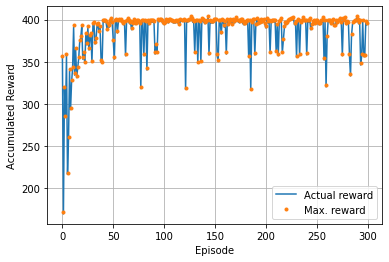

In [106]:
plt.plot(episode_reward, label='Actual reward')
plt.plot(max_reward, '.', label='Max. reward')
plt.xlabel('Episode')
plt.ylabel('Accumulated Reward')
plt.grid()
plt.legend()
plt.show()

In [107]:
print(len(rewards))

30000


In [108]:
# RESULTADO SEM USAR O LIST SLICING
rewards0 = np.array(rewards)
print("mean value: ", np.mean(rewards0), " std:", np.std(rewards0), " min:", min(rewards0), " max:", max(rewards0))

mean value:  383.98363333333333  std: 24.105643159480774  min: 157.0  max: 404.0


In [109]:
# RESULTADO USANDO O LIST SLICING para pegar os N últimos elementos da lista
# initializing N
N = 396 #356 #396
 
# using list slicing
# Get last N elements from list
res = rewards[-N:]

In [110]:
rewards_test = np.array(res)
print("mean value: ", np.mean(rewards_test), " std:", np.std(rewards_test), " min:", min(rewards_test), " max:", max(rewards_test))

mean value:  385.8156565656566  std: 25.28212242806983  min: 169.0  max: 402.0


In [111]:
max_reward

array([357., 171., 320., 286., 359., 218., 261., 341., 295., 328., 344.,
       393., 336., 366., 333., 344., 356., 376., 380., 394., 355., 361.,
       350., 384., 372., 392., 366., 382., 384., 351., 396., 397., 373.,
       378., 395., 396., 387., 392., 352., 350., 400., 399., 400., 398.,
       389., 396., 393., 400., 402., 397., 376., 355., 400., 401., 386.,
       400., 401., 400., 401., 398., 396., 398., 359., 399., 402., 400.,
       397., 398., 390., 396., 401., 398., 396., 399., 400., 398., 396.,
       320., 399., 399., 359., 399., 398., 342., 399., 396., 400., 399.,
       399., 399., 398., 361., 371., 362., 401., 400., 401., 401., 399.,
       397., 396., 397., 401., 399., 398., 401., 401., 400., 399., 398.,
       398., 398., 400., 398., 399., 395., 401., 400., 400., 401., 400.,
       319., 400., 399., 401., 401., 404., 402., 399., 398., 362., 399.,
       399., 350., 400., 398., 351., 402., 401., 399., 397., 398., 399.,
       404., 360., 400., 398., 398., 398., 401., 40

In [112]:
episode_reward

array([355., 169., 318., 284., 357., 216., 259., 339., 293., 326., 342.,
       391., 334., 364., 331., 342., 354., 374., 378., 392., 353., 359.,
       348., 382., 370., 390., 364., 380., 382., 349., 394., 395., 371.,
       376., 393., 394., 385., 390., 350., 348., 398., 397., 398., 396.,
       387., 394., 391., 398., 400., 395., 374., 353., 398., 399., 384.,
       398., 399., 398., 399., 396., 394., 396., 357., 397., 400., 398.,
       395., 396., 388., 394., 399., 396., 394., 397., 398., 396., 394.,
       318., 397., 397., 357., 397., 396., 340., 397., 394., 398., 397.,
       397., 397., 396., 359., 369., 360., 399., 398., 399., 399., 397.,
       395., 394., 395., 399., 397., 396., 399., 399., 398., 397., 396.,
       396., 396., 398., 396., 397., 393., 399., 398., 398., 399., 398.,
       317., 398., 397., 399., 399., 402., 400., 397., 396., 360., 397.,
       397., 348., 398., 396., 349., 400., 399., 397., 395., 396., 397.,
       402., 358., 398., 396., 396., 396., 399., 39

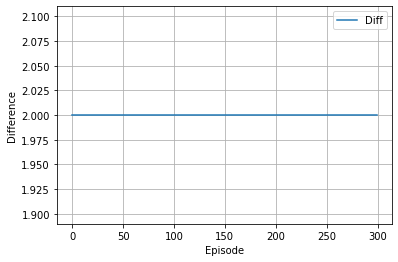

In [113]:
diff  = (max_reward - episode_reward)
plt.plot(diff, label='Diff')
plt.xlabel('Episode')
plt.ylabel('Difference')
plt.grid()
plt.legend()
plt.show()

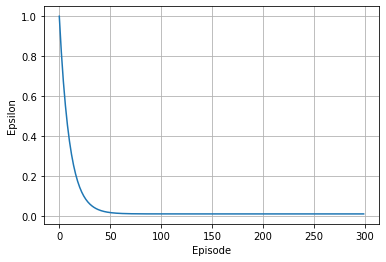

In [114]:
plt.plot(epsilon_vec)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid()
plt.show()